In [1]:
import yaml, pathlib, requests, os
import zipfile

with open("config.yaml") as f:
    config = yaml.safe_load(f)
RAW_DIR = pathlib.Path(config["raw_data_dir"])
DATASETS_DIR = RAW_DIR / "datasets"
DATASETS_DIR.mkdir(parents=True, exist_ok=True)

ZIP_PATH = DATASETS_DIR / "central_southamerica.zip"
URL = "https://datacatalogfiles.worldbank.org/ddh-published/0040289/DR0050247/central_southamerica.zip"

if not ZIP_PATH.exists():
    print("→ Downloading central_southamerica.zip …")
    with requests.get(URL, stream=True, timeout=60) as r:
        r.raise_for_status()
        with open(ZIP_PATH, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print(f"✓ Saved to {ZIP_PATH}")
else:
    print("✓ Archive already present:", ZIP_PATH)


with zipfile.ZipFile(ZIP_PATH, "r") as zf:
    zf.extractall(DATASETS_DIR)
    print(f"✓ Extracted all to {DATASETS_DIR}")

✓ Archive already present: data/raw/datasets/central_southamerica.zip
✓ Extracted all to data/raw/datasets


In [2]:
import geopandas as gpd
import pyogrio, pprint
import pandas as pd
PROCESSED_DIR = pathlib.Path(config["processed_data_dir"])
TILES_PKL = PROCESSED_DIR / "all_tiles_flat.pkl"
tiles = pd.read_pickle(TILES_PKL)
if tiles.crs is None or tiles.crs.to_epsg() != 3857:
    tiles = tiles.set_crs(3857, allow_override=True)

gdb_dirs = [p for p in DATASETS_DIR.rglob("*.gdb") if p.is_dir()]
if not gdb_dirs:
    raise FileNotFoundError("No .gdb found after extraction!")
gdb_path = gdb_dirs[0]
layers = list(pyogrio.list_layers(gdb_path))
print("layers in GDB:")
pprint.pp(layers)
layer_name = layers[0][0]  

roads = gpd.read_file(gdb_path, layer=layer_name, engine="pyogrio")
if roads.crs is None or roads.crs.to_epsg() != 3857:
    roads = roads.to_crs(3857)

from shapely.geometry import box
minx, miny, maxx, maxy = tiles.total_bounds
aoi = box(minx-10_000, miny-10_000, maxx+10_000, maxy+10_000)
roads_clip = roads.clip(aoi)
print(f"roads inside AOI: {len(roads_clip):,} / {len(roads):,}")


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/envs/archaeo/share/proj failed


layers in GDB:
[array(['GRIP4_region2', 'MultiLineString'], dtype=object)]
roads inside AOI: 791,307 / 3,083,547


/tmp/ipykernel_519/3463783034.py:9: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


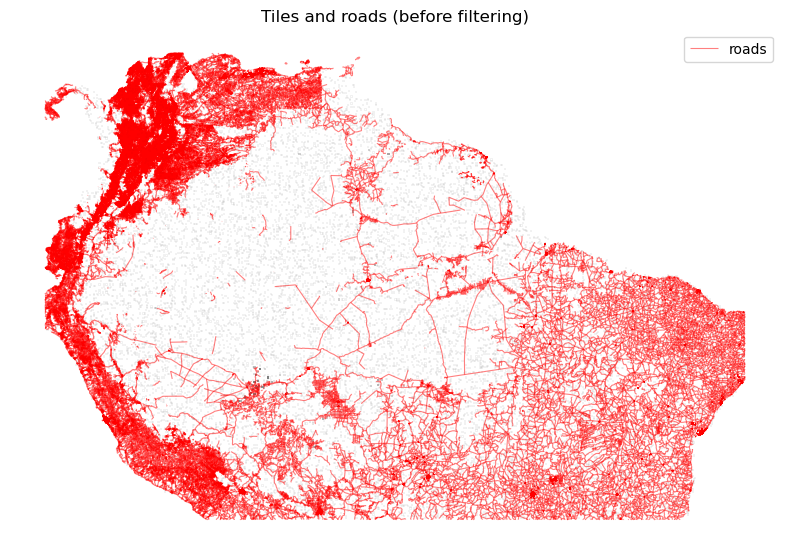

→ Building spatial index …


100%|██████████| 17537/17537 [00:03<00:00, 5312.70it/s]


✓ Remaining tiles: 10,120  (57.7% of original)


/tmp/ipykernel_519/3463783034.py:35: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


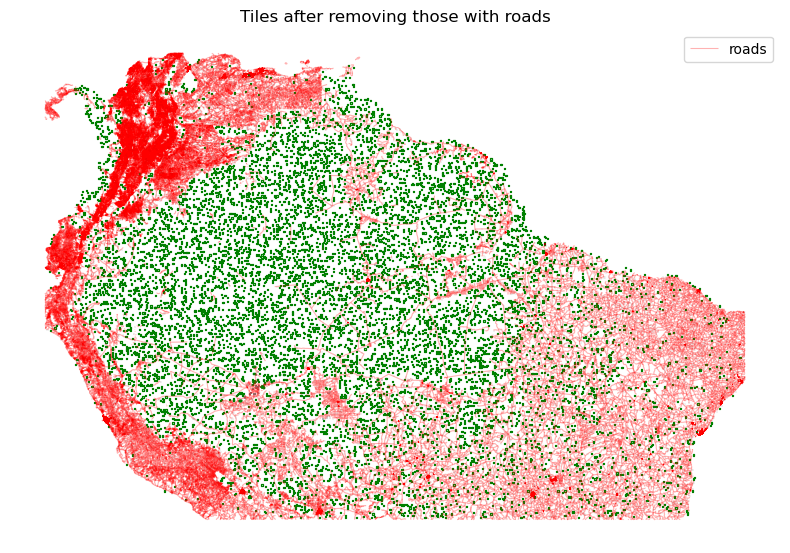

In [7]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- plot tiles and roads before filtering
fig, ax = plt.subplots(figsize=(8,8))
tiles.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=0.5, alpha=0.15, label="tiles")
roads_clip.plot(ax=ax, color="red", linewidth=0.8, alpha=0.5, label="roads")
ax.set_title("Tiles and roads (before filtering)")
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()

# --- filter mask for tiles that do not intersect roads
print("→ Building spatial index …")
ridx = roads_clip.sindex
keep_mask = []
for poly in tqdm(tiles.geometry, total=len(tiles)):
    cand_idx = list(ridx.query(poly, predicate="intersects"))
    if not cand_idx:
        keep_mask.append(True)
    else:
        keep_mask.append(
            not roads_clip.iloc[cand_idx].intersects(poly).any()
        )
clean_tiles = tiles.loc[keep_mask].copy()
print(f"✓ Remaining tiles: {len(clean_tiles):,}  ({len(clean_tiles)/len(tiles):.1%} of original)")

# after filtering, reset index
fig, ax = plt.subplots(figsize=(8,8))
tiles.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=0.5, alpha=0.15, label="all tiles")
clean_tiles.plot(ax=ax, edgecolor="green", facecolor="none", linewidth=0.9, label="filtered tiles")
roads_clip.plot(ax=ax, color="red", linewidth=0.8, alpha=0.3, label="roads")
ax.set_title("Tiles after removing those with roads")
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [4]:
# %%
OUT_PKL = PROCESSED_DIR / "all_tiles_without_roads.pkl"
clean_tiles.to_pickle(OUT_PKL)
print("✓ Saved to", OUT_PKL)


✓ Saved to data/processed/all_tiles_without_roads.pkl
